# Transformer model

**Install and import packages**

In [1]:
%pip install --upgrade jupyter
%pip install pandas
%pip install cmake
%pip install lightgbm
%pip install darts
%pip install seaborn
%pip install optuna
%pip install matplotlib
%pip install joblib
%pip install seaborn
%pip install tqdm
%pip install torch
%pip install sklearn
%pip install scikit-learn
%pip install pandas_profiling

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [20]:
#Imports

# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
import heapq

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

#hmm needed? 
import torch
import torch.nn as nn
#from torch import nn
import torch.optim as optim
import shutil
import sklearn
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import * #everything

#loss metrics
from darts.metrics import mape
from darts.metrics import smape
from darts.utils.losses import SmapeLoss

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#hyperparameter tuning
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

#extras
import os
import time
import random
from datetime import datetime
from itertools import product
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import statistics


# Load data

**Define loading and preprocessing function**

In [21]:
def load_preprocess(csv_file):

    ''' Loading and preprocessing data from csv. Return list of time-series IDs and preprocessed csv.'''

    #Read data
    raw_data = pd.read_csv(csv_file)

    #Cut off before 1950
    raw_data = raw_data[raw_data['Year'] >= 1950]

    #Transform timestamp to datetime format
    raw_data['Year'] = pd.to_datetime(raw_data['Year'], format='%Y')

    #Drop "Code" column
    raw_data = raw_data.drop(['Code'], axis=1)

    #Rename columns
    raw_data = raw_data.rename(columns={"Life expectancy at birth (historical)":"LE", "Entity":"Country"})

    #Exclude entries that are not countries/territories
    exclude = ['Africa', 'Asia','Americas', 'Europe', 'High-income countries', 'More developed regions','Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World']

    # Subset the DataFrame based on the countries/territories of interest
    data_countries = raw_data.loc[~raw_data['Country'].isin(exclude)]

    #create list of countries for later
    countries = list(data_countries["Country"].unique())

    #Write to csv
    data_countries.to_csv('life_expectancy_data.csv', index=False)

    #Get dataframe for further work
    data_pd = pd.DataFrame(data_countries)

    return countries, data_pd

# Transformer

**Splits**

Training: 52 years (1950-2001) = 70%

Validation: 10 years (2002-2011) = 15%

Testing: 10 years (2012-2021) = 15%

Forecasting horizon: 10 years.

We load the data from DataFrame again to make new splits.

**Define functions**

In [30]:
def transform_split_scale(dataframe: pd.DataFrame) -> Tuple[List[TimeSeries], List[TimeSeries],List[TimeSeries],List[TimeSeries]]:
    
    ''' Transform DataFrame to TimeSeries object. Scale data from 0-1.
    Split in train, vald, and test. Return full TimeSeries object, train TimeSeries object, and test TimeSeries object. '''

    #To timeseries
    dataset_ts = TimeSeries.from_group_dataframe(df=data_pd, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')

    #Scale 
    scaler = Scaler(scaler=MaxAbsScaler()) 
    data_scaled = scaler.fit_transform(dataset_ts)

    # Split train/val/test
    print("splitting train/val/test...")
    train_scaled: List[TimeSeries] = [s[:-2*HORIZON] for s in data_scaled]
    val_scaled: List[TimeSeries] = [s[-2*HORIZON:-HORIZON] for s in data_scaled]
    test_scaled: List[TimeSeries] = [s[-HORIZON:] for s in data_scaled]

    print("There are in total {} series".format(len(train))),
    print("Years applied for training: {}".format(np.mean([len(s) for s in train_scaled])),
    print("Years applied for validation (forecasting horizon): {}".format(np.mean([len(s) for s in val_scaled])),
    print("Years applied for testing (forecasting horizon): {}".format(np.mean([len(s) for s in test_scaled]))
        )
    )
    )
    return data_scaled, train_scaled, val_scaled, test_scaled

def eval_forecasts(
    name,
    pred_series: List[TimeSeries], 
    test_or_val_series: List[TimeSeries],
) -> List[float]:
    ''' Computing sMAPEs between predictions and ground truth (test data). 
    Plotting the distribution and retrieving the median sMAPE. '''
    print("computing sMAPEs...")
    smapes = smape(test_or_val_series, pred_series)
    plt.figure(figsize=(8,6))
    #plt.hist(smapes, bins=50)
    sns.histplot(smapes,kde=True, color='blue')
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("Model: {}".format(name))
    subtitle = "Median sMAPE: {:.3f} and mean sMAPE: {:.2f} +- {:.2f}".format(np.median(smapes), np.mean(smapes), np.std(smapes))
    plt.text(0.5, 0.92, subtitle, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.show()
    plt.close()
    return smapes

def eval_model(preds, name, true_data, val_or_test_set):
    ''' Extract sMAPEs for predictions on test set. Plot actual versus prediction.'''
    
    smapes = smape(preds, val_or_test_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    # Extract sMAPES per time-series and time-series with highest sMAPEs
    smapes_pr_country = list(zip(countries, smapes))
    highest_smapes = heapq.nlargest(10, smapes_pr_country, key=lambda x: x[1])
    
    # Determine the number of rows and columns for subplots
    num_plots = 4
    num_rows = int(np.ceil(num_plots / 2))
    num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle("Actual vs. Forecast", fontsize=16)
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for i, ax in enumerate(axes):
        if i < len(true_data):
            true_data[i].plot(ax=ax, label = "Life Expectancy")
            val_or_test_set[i].plot(ax=ax, label="Actual")  # Plot actual data
            preds[i].plot(ax=ax, label="Forecast")  # Plot forecast data

            ax.set_xlabel("Time")
            ax.set_ylabel("Value")
            ax.set_title("{}".format(countries[i]))
            ax.legend()

    # Hide unused subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    return smapes_pr_country, highest_smapes

def sMAPE_stats(smapes_pr_country, threshold = int):
    threshold = threshold
    _above = [item for item in smapes_pr_country if item[1] > threshold]
    _below = [item for item in smapes_pr_country if item[1] <= threshold]
    _above_values = [item[1] for item in _above]
    _below_values = [item[1] for item in _below]
    print("There are {} series with an sMAPE above {}".format(len(_above), threshold))
    print("There are {} series with an sMAPE of or beneath {}".format(len(_below), threshold))
    print("Statistics for highest sMAPEs:")
    print("The mean error for series with an sMAPE above {} is {}".format(threshold, statistics.mean(_above_values)))
    print("The sd for series with an sMAPE above {} is {}".format(threshold, statistics.stdev(_above_values)))
    print("The median error for series with an sMAPE above {} is {}".format(threshold, statistics.median(_above_values)))
    print("Statistics for lowest sMAPEs:")
    print("The mean error for series with an sMAPE of or below {} is {}".format(threshold, statistics.mean(_below_values)))
    print("The sd for series with an sMAPE of or below {} is {}".format(threshold, statistics.stdev(_below_values)))
    print("The median error for series with an sMAPE of or below {} is {}".format(threshold, statistics.median(_below_values)))

**Preprocess data**

In [8]:
#Define horizon
HORIZON = 10

#Preprocess
countries, data_pd = load_preprocess('life-expectancy.csv')

#Load
data_scaled, train_scaled, val_scaled, test_scaled = transform_split_scale(data_pd)

splitting train/val/test...
There are in total 237 series
Years applied for testing (forecasting horizon): 10.0
Years applied for validation (forecasting horizon): 10.0 None
Years applied for training: 52.0 None


**Define and train transformer** 

In [9]:
def build_fit_model(
    IN_LEN,
    OUT_LEN,
    D_MODEL,
    N_HEAD,
    likelihood=None,
    callbacks=None,
    data = List[TimeSeries],
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters
    BATCH_SIZE = 16 #Number of time series (input and output sequences) used in each training pass. Default: 32.
    MAX_N_EPOCHS = 30 #Max number of epoch if early stopping not applied
    NR_EPOCHS_VAL_PERIOD = 1 #Number of epochs to wait before evaluating the validation loss
    #MAX_SAMPLES_PER_TS = 72 skipped as series are short
    ENCODER_LAYERS = 2 #few bc univariate and no seasonality - default 3
    DECODER_LAYERS = 2 #few bc univariate and no seasonality - default 3
    DIM_FEEDFORWARD = 128 #The dimension of the feedforward network model (default=512).

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.05, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    model = TransformerModel(
        input_chunk_length=IN_LEN,
        output_chunk_length=OUT_LEN,
        batch_size=BATCH_SIZE,
        n_epochs=MAX_N_EPOCHS,
        model_name="transformer_model",
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        d_model=D_MODEL,
        nhead=N_HEAD,
        num_encoder_layers=ENCODER_LAYERS,
        num_decoder_layers=DECODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=0.1,
        activation="relu",
        random_state=42,
        #optimizer_kwargs={"lr": lr}
        save_checkpoints=True, #save the best model and discard the rest (I think)
        force_reset=True,
    )

    # when validating during training, we can use a slightly longer validation set 
    # which also contains the first input_chunk_length time steps
    model_val_set = [s[-((2 * HORIZON) + IN_LEN) : -HORIZON] for s in data_scaled]

    # train the model
    print("fitting model...")
    model.fit(
        series=train_scaled,
        val_series=model_val_set,
        #max_samples_per_ts=MAX_SAMPLES_PER_TS,
    )

    # reload best model over course of training
    print("loading best model...")
    best_model = model.load_from_checkpoint("transformer_model")

    return best_model

# Hyperparameter optimization

**Define function for optimization**

In [ ]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, 4 and 10 years
    in_len = trial.suggest_int("years_in", 4, 10)

    # set out_len, between 1 and 9 years (it has to be strictly shorter than in_len).
    out_len = trial.suggest_int("years_out", 1, 9)

    # Other hyperparameters
    d_model = trial.suggest_int("D_MODEL", 16, 128)
    n_head = trial.suggest_int("N_HEAD", 2, 8)

    # build and train the model with these hyper-parameters:
    model = build_fit_model(
        IN_LEN =in_len,
        OUT_LEN =out_len,
        D_MODEL = d_model,
        N_HEAD = n_head,
        data = data_scaled,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=train_scaled, n=HORIZON)
    smapes = smape(val_scaled, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

**Optimize**

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")

study.optimize(objective, timeout=7200, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
#study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# Transformer, tuned

Best value: 1.302255380588254

Best params: {'years_in': 9, 'years_out': 3, 'D_MODEL': 120, 'N_HEAD': 3}

In [ ]:
best_model = build_fit_model(
    IN_LEN = 9,
    OUT_LEN = 3,
    D_MODEL = 120, 
    N_HEAD = 3,
    data = data_scaled,
    )

In [11]:
#Save
best_model.save("tuned_transformer.pkl")

**Extract predictions for test horizon and evaluate**

In [39]:
#Extract model 
best_model = TransformerModel.load("tuned_transformer.pkl")

Predicting: 0it [00:00, ?it/s]

computing sMAPEs...


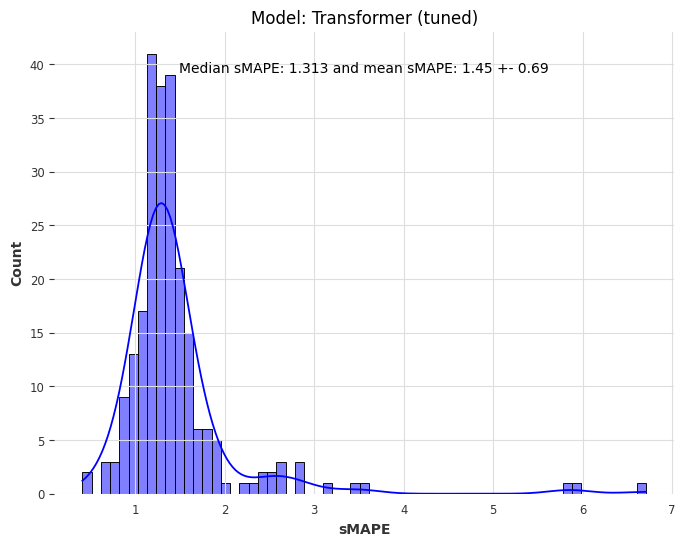

[1.3089351825039244,
 1.203397238471962,
 1.1549535956860664,
 1.6179401728909595,
 1.2058466185209584,
 2.4972472998943056,
 0.7020889180378437,
 1.3967616896751325,
 1.1431373943810335,
 1.3967240447245266,
 1.1950789314060157,
 0.7666222387315913,
 1.3947968710587126,
 1.8839795302930544,
 1.2620660333559925,
 1.2425652913742773,
 1.3007559123529902,
 1.2455196074038037,
 1.6988247403029157,
 1.173320981422419,
 1.5847686675863095,
 1.0759019122092852,
 0.8496697041120256,
 1.2543294611661249,
 1.902994165072685,
 0.866452893657255,
 1.0941118066178905,
 2.850929636505082,
 1.221307795816602,
 1.2321583582884548,
 1.4056174888966049,
 1.425452945451175,
 1.601221115198137,
 1.8960060575711175,
 1.5596157017886836,
 1.8028834672896252,
 1.1971507162370771,
 0.9715656792356651,
 0.7152670339749508,
 2.349516978788816,
 1.3587800316105676,
 1.131719538085679,
 1.254651302314726,
 1.5371491973440587,
 1.3320253138889269,
 1.281178672462575,
 1.376025597433551,
 1.4427637894832395,
 1.80

In [40]:
train_val_set = [s[:-HORIZON] for s in data_scaled]

best_preds_transformer = best_model.predict(series=train_val_set, n=HORIZON)
eval_forecasts("Transformer (tuned)", best_preds_transformer, test_scaled)

In [ ]:
#Extract countries with highest errors
print(highest_smapes_transformer)

#Extract central statistics of sMAPEs
sMAPE_stats(smapes_pr_country_transformer, threshold = 5)